In [78]:
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
from scipy.interpolate import interp1d
import pandas as pd
from scipy.special import jv
from scipy.linalg import solve_sylvester

def get_square_H(s,skin_depth,resolution,H0=1):
    k = (1-1j)/skin_depth
    dx = s/resolution #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize data matrix
    # Ymat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize B matrix
    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 

    H_beta_x = -H0*beta_x

    C[0][0] = 2*H_beta_x
    C[resolution-1][0] = 2*H_beta_x
    C[0][resolution-1] = 2*H_beta_x
    C[resolution-1][resolution-1] = 2*H_beta_x

    for i in range(1,resolution-1):
        C[0][i] = H_beta_x
        C[resolution-1][i] = H_beta_x
        C[i][0] = H_beta_x
        C[i][resolution-1] = H_beta_x
        
    X = solve_sylvester(Xmat,Xmat,C)
    
    for i in range(resolution):
        for j in range(resolution):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).
    # print(X-solve_sylvester(Xmat,Xmat,C))             
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX

def get_cylind_H(d,skin_depth,resolution,H0=1):
    k = (1-1j)/skin_depth
    cylindH = H0 * np.ones([resolution+2,resolution+2],dtype=np.complex_)
    for i in range(resolution+2):
        for j in range(resolution+2):
            r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*d
            if r<=d/2:
                # print(np.sqrt((i-(resolution+2)/2)**2 + (j-(resolution+2)/2)**2)/(resolution+2),end='')
                cylindH[i][j] = jv(0,r*k)/jv(0,d/2*k)
    return cylindH

def get_shape_H_Show_Phase(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    x = np.linspace(0, s, resolution)  # x-axis points
    dx = x[1] - x[0]  # grid spacing in x

    # Define the initial condition
    z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    phases = np.zeros(iterations)
    # for i in range(1, resolution - 1):  # loop over the interior points in x
    #     for j in range(1, resolution - 1):  # loop over the interior points in y
    #         if mask[i, j] == 1:
    #             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
    #             za = jv(0,r*k)/jv(0,s/2*k)
    #             if np.absolute(za) < 1:
    #                 z[i,j] = za
    #             else:
    #                 z[i,j] = 1
    z = better_guess(mask,s,skin_depth)
    # fig1 = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
    # a2x = fig1.add_subplot(1, 1, 1)
    # p1 = a2x.imshow(np.absolute(z),norm=colors.LogNorm(vmin=np.absolute(z).min(), vmax=1))
    # fig1.colorbar(p1, ax=a2x)
    # a2x.set_xlabel('Sample Length (mm)')
    # a2x.set_ylabel('Sample Height (mm)')
    # a2x.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
        phases[n] = np.angle(double_Integral(z,s)/s**2-1)
    i1 = np.logical_not(phases<0)
    phases[i1]-= 2*np.pi

    fig = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.arange(iterations),phases)
    ax.set_xlabel('Number of Iterations (mm)')
    ax.set_ylabel('Phase (rad)')
    ax.set_title('Phase behavior')
    return z

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    x = np.linspace(0, s, resolution)  # x-axis points
    dx = x[1] - x[0]  # grid spacing in x

    # Define the initial condition
    z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    # shape_inds = np.array([])
    # for i in range(1, resolution - 1):  # loop over the interior points in x
    #     for j in range(1, resolution - 1):  # loop over the interior points in y
    #         if mask[i, j] == 1:
    #             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
    #             z[i,j] = jv(0,r*k)/jv(0,s/2*k)
    #             # shape_inds = np.append(shape_inds,(i,j))


    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # for n in range(iterations):
    #     old_z = z.copy()
    #     for i in range(1, resolution - 1):  # loop over the interior points in x
    #         for j in range(1, resolution - 1):  # loop over the interior points in y
    #             if mask[i, j] == 1:  # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (old_z[i+1, j] + old_z[i-1, j] + old_z[i, j+1] + old_z[i, j-1]) * inv_denom

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])

    # Time to iterate_new ...slower??
    # inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # inx = np.transpose(np.where(mask == 0))
    # print(inx)
    # for n in range(iterations):
    #     for i,j in inx: # loop over the interior points in   
    #                 # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    return z

def get_rect_H(l,w,skin_depth,resolution,iters):
    big = max(l,w)
    ratio = min(l,w)/big
    mask = np.zeros([resolution,resolution],dtype=np.float64)
    for i in range(resolution):
        if abs(i/(resolution-1)-.5)< ratio/2: #so the difference from the center point (.5) is ratio/2 or less for each side
            row = [1]*resolution
            row[0] = 0
            row[-1] = 0
            mask[i] = np.array([row])
    return get_shape_H(mask,big,skin_depth,iters)
    # fig = plt.figure(constrained_layout = True)
    # ax = fig.add_subplot(1, 1, 1)
    # ax.imshow(np.absolute(mask))
    # ax.set_xticks(np.arange(0, resolution, step=10))
    # ax.set_yticks(np.arange(0, resolution, step=10))
    # return ''
    
def get_skin_depth(rho,frequency=671111):
    return (2*rho/(4e-7*np.pi*2 * np.pi *frequency))**.5

def adjustsize(data, start,end,resolution,outside_val=0):
    if end < start:
        return data
    n = int(end/start*resolution) #new matrix size
    starting_ind = int(resolution*(end/start-1)/2)
    output = np.zeros([n,n],dtype=np.complex_)+outside_val
    for i in range(resolution+2):# assuming the matrix has an outside row of 1s, so its size is resolution +2
        for j in range(resolution+2):
            output[starting_ind + i - 1][starting_ind + j - 1] = data[i][j]
    return output

def double_Integral(data, d):
    n = len(data)#assumes square 2d array that has physical length of d by d meters
    dA = ((d-0)/(n-1)) * ((d-0)/(n-1))

    data_Internal = data[1:-1, 1:-1]

    # sides: up, down, left, right
    (data_u, data_d, data_l, data_r) = (data[0, 1:-1], data[-1, 1:-1], data[1:-1, 0], data[1:-1, -1])

    # corners
    (data_ul, data_ur, data_dl, data_dr) = (data[0, 0], data[0, -1], data[-1, 0], data[-1, -1])

    return dA * (np.sum(data_Internal)\
                + 0.5 * (np.sum(data_u) + np.sum(data_d) + np.sum(data_l) + np.sum(data_r))\
                + 0.25 * (data_ul + data_ur + data_dl + data_dr))

def get_area(mask,s):
    count = 0
    for i in range(len(mask)):
        for j in range(len(mask[0])):
            if mask[i][j]:
                count += 1
    return s**2*count/(len(mask)*len(mask[0])) #this gives area in units of s**2

def get_nearest_edge(mask,s):
    radii = np.zeros([len(mask),len(mask[0])],dtype=np.float64)
    for i in range(1, len(mask) - 1):  # loop over the interior points in x
        for j in range(1, len(mask[0]) - 1):  # loop over the interior points in y
            reach = 1
            if mask[i, j]:
                r = np.Infinity# r is defined to be the distance between centers of pixels in units of a single pixel length
                while reach < r:
                    if (not(mask[i+reach,j]) or not(mask[i-reach,j]) or not(mask[i,j+reach]) or not(mask[i,j+reach])) and r>reach:#check edge centers if odd
                            r = reach
                            break #if this ever happens, it is always the shortest path because every next point is farther away
                    for edge in range(1,reach): #then check two sqaures on either edge of edge center (eight total places to check for each distance)
                        if (not(mask[i+reach,j+edge]) or not(mask[i+reach,j-edge]) or 
                            not(mask[i-reach,j+edge]) or not(mask[i-reach,j-edge]) or 
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach]) or
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach])) and r**2>reach**2+edge**2:#check edge centers if odd
                            r = np.sqrt(reach**2+edge**2)
                            break # this breaks of because each next edge is farther
                    if (not(mask[i+reach,j+reach]) or not(mask[i-reach,j+reach]) or not(mask[i+reach,j-reach]) or not(mask[i-reach,j-reach])) and r>reach*2**.5:#check edge centers if odd
                            r = reach*2**.5 #check corners
                    reach += 1 #move out a layer
                radii[i,j] = r*s/len(mask)
    return radii

def better_guess(mask,s,skin_depth):
    a = np.sqrt(get_area(mask,s)/np.pi) #this is the radius of the circle with the same area of the mask
    rs = get_nearest_edge(mask,s)
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    good_guess = np.ones((resolution, resolution), dtype=np.complex128)
    i = np.logical_not(mask == 0)
    good_guess[i] = jv(0,(a-rs[i])*k)/jv(0,a*k)
    return good_guess

Text(0.5, 1.0, '1 mm$^2$ Copper Triangle Cross Section')

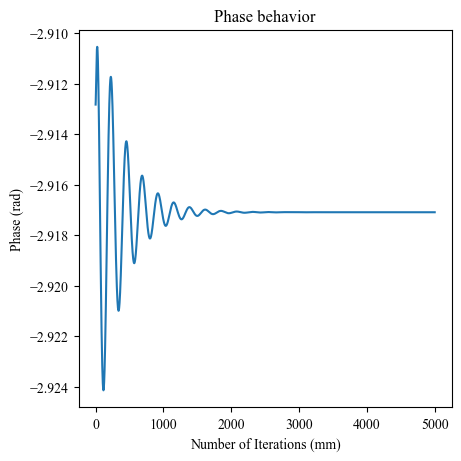

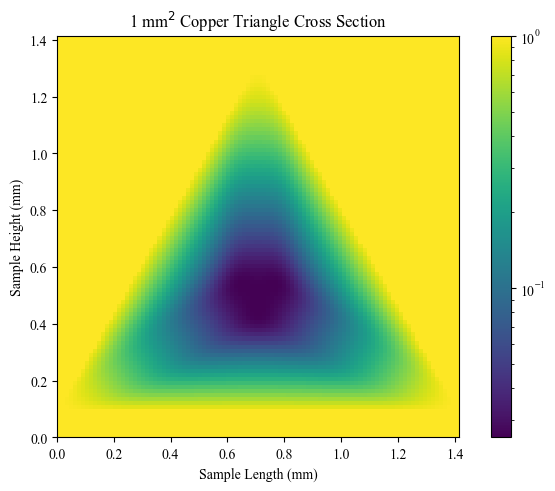

In [79]:
# Triangle plot

tri_resolution = 100
iter = 5000
l = 2**(.5)*1e-3 #this is the legnth of all the sides of triangle. This will gave an area of 1mm^2
tri_data = np.zeros([tri_resolution,tri_resolution])
diff = int((tri_resolution - (tri_resolution*3**.5)//2)//2)
for i in range(int((tri_resolution*3**.5)//2)):
    for j in range(tri_resolution):
        if i>=3**.5*abs(j-(tri_resolution-1)/2):# or i<=2*abs(j-(tri_resolution-1)/2):
            tri_data[i][j] = 1
tri_data2 = np.zeros([tri_resolution,tri_resolution])
tri_data2[diff:int((tri_resolution*3**.5)//2)+1+diff] = tri_data[:int((tri_resolution*3**.5)//2)+1]
# fig = plt.figure(constrained_layout = True)
# ax = fig.add_subplot(1, 1, 1)
# ax.imshow(np.absolute(tri_data2))
# ax.set_yticks(np.arange(0, tri_resolution, step=10))
# plt.show()
tri_H = get_shape_H_Show_Phase(tri_data2,l,get_skin_depth(2e-8),iter)

fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(1, 1, 1)

p1 = ax.imshow(np.absolute(tri_H),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=np.absolute(tri_H).min(), vmax=1))#,norm=colors.LogNorm(vmin=min(np.absolute(tri_H )), vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

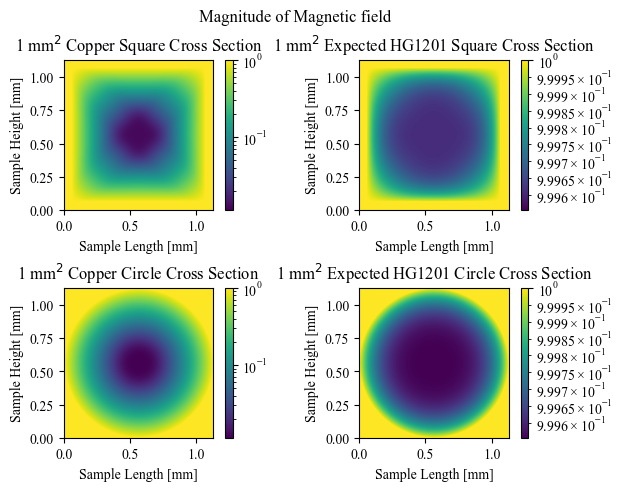

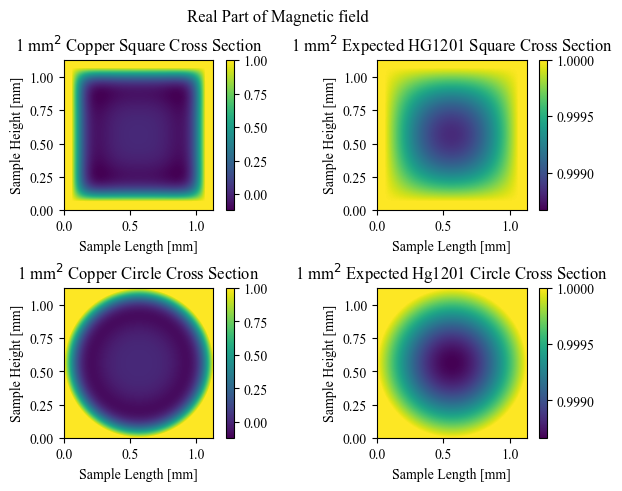

Text(0.5, 1.0, '1 mm$^2$ Expected HG1201 Circle Cross Section')

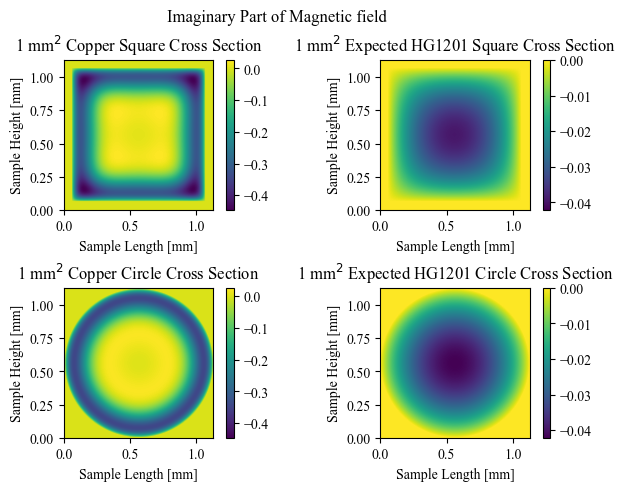

In [47]:
# Square v Circle (real, imaginary, and phase comparison)

cylind_resolution = 150
square_resolution = 150
s = 1e-3 # length in meters
d = 2e-3/np.pi**.5 #diameter in meters


rho = np.array([2e-8,1000e-8]) #resistivities in ohm*m
skin_depths = get_skin_depth(rho)
CopperSquare = get_square_H(s,skin_depths[0],square_resolution)
CopperCylind = get_cylind_H(d,skin_depths[0],cylind_resolution)
InsolSquare = get_square_H(s,skin_depths[1],square_resolution)
InsolCylind = get_cylind_H(d,skin_depths[1],cylind_resolution)

CopperSquare_ad = adjustsize(CopperSquare,1,2/np.pi**.5,square_resolution,1)
InsolSquare_ad = adjustsize(InsolSquare,1,2/np.pi**.5,square_resolution,1)

coppermin = min(np.absolute(CopperSquare).min(),np.absolute(CopperCylind).min())
insolmin = min(np.absolute(InsolSquare).min(),np.absolute(InsolCylind).min())


fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)
fig.suptitle('Magnitude of Magnetic field')

p1 = ax.imshow(np.absolute(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.absolute(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=insolmin, vmax=1))
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length (mm)')
bx.set_ylabel('Sample Height (mm)')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.absolute(CopperCylind),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length (mm)')
cx.set_ylabel('Sample Height (mm)')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.absolute(InsolCylind),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=insolmin, vmax=1))
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length (mm)')
dx.set_ylabel('Sample Height (mm)')
dx.set_title(r'1 mm$^2$ Expected HG1201 Circle Cross Section')

coppermin = min(np.real(CopperSquare).min(),np.real(CopperCylind).min())
insolmin = min(np.real(InsolSquare).min(),np.real(InsolCylind).min())
coppermax = max(np.real(CopperSquare).max(),np.real(CopperCylind).max())
insolmax = min(np.real(InsolSquare).max(),np.real(InsolCylind).max())

fig = plt.figure(constrained_layout = True)
fig.suptitle('Real Part of Magnetic field')
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.real(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.real(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length (mm)')
bx.set_ylabel('Sample Height (mm)')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.real(CopperCylind),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length (mm)')
cx.set_ylabel('Sample Height (mm)')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.real(InsolCylind),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length (mm)')
dx.set_ylabel('Sample Height (mm)')
dx.set_title(r'1 mm$^2$ Expected Hg1201 Circle Cross Section')

coppermin = min(np.imag(CopperSquare).min(),np.imag(CopperCylind).min())
insolmin = min(np.imag(InsolSquare).min(),np.imag(InsolCylind).min())
coppermax  = max(np.imag(CopperSquare).max(),np.imag(CopperCylind).max())
insolmax = max(np.imag(InsolSquare).max(),np.imag(InsolCylind).max())

fig = plt.figure(constrained_layout = True)
fig.suptitle('Imaginary Part of Magnetic field')
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.imag(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.imag(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length (mm)')
bx.set_ylabel('Sample Height (mm)')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.imag(CopperCylind),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length (mm)')
cx.set_ylabel('Sample Height (mm)')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.imag(InsolCylind),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length (mm)')
dx.set_ylabel('Sample Height (mm)')
dx.set_title(r'1 mm$^2$ Expected HG1201 Circle Cross Section')

Text(0.5, 1.0, '1 mm$^2$ Copper Triangle Cross Section')

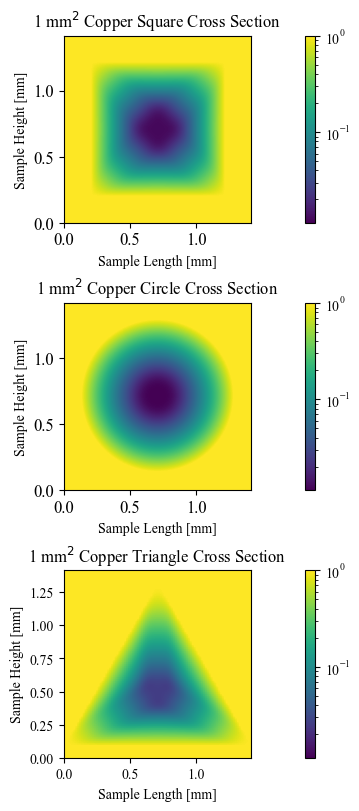

In [48]:
# Circle v Square v Triangle Field

CopperSquare_ad = adjustsize(CopperSquare,s,l,square_resolution,1)
CopperCylind_ad = adjustsize(CopperCylind,d,l,cylind_resolution,1)

coppermin = min(np.absolute(CopperSquare).min(),np.absolute(CopperCylind).min(),np.absolute(tri_H).min())

fig = plt.figure(constrained_layout = True,figsize=(12,8))
ax = fig.add_subplot(3, 1, 1)
bx = fig.add_subplot(3, 1, 2)
cx = fig.add_subplot(3, 1, 3)
p1 = ax.imshow(np.absolute(CopperSquare_ad),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

p2 = bx.imshow(np.absolute(CopperCylind_ad),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length (mm)')
bx.set_ylabel('Sample Height (mm)')
bx.set_title(r'1 mm$^2$ Copper Circle Cross Section')
bx.tick_params(axis='x', labelsize=12)
bx.tick_params(axis='y', labelsize=12)

p3 = cx.imshow(np.absolute(tri_H),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length (mm)')
cx.set_ylabel('Sample Height (mm)')
cx.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

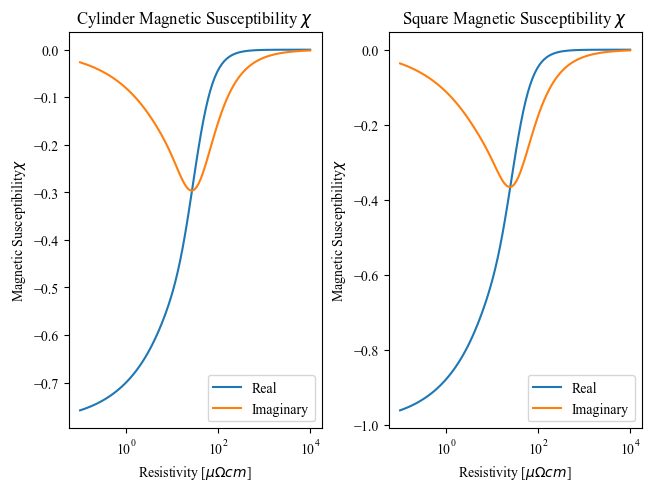

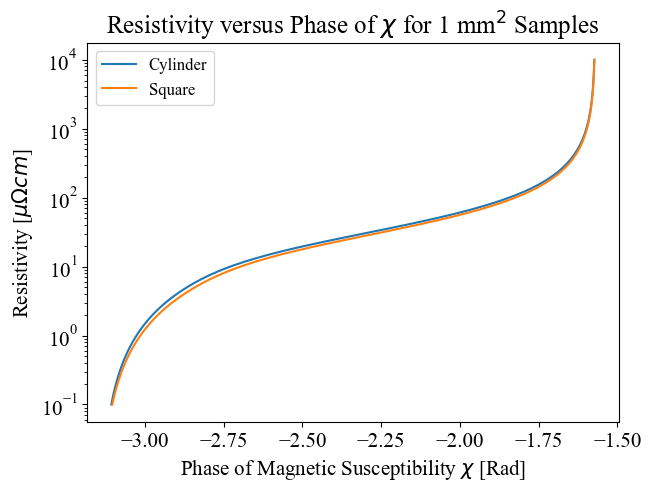

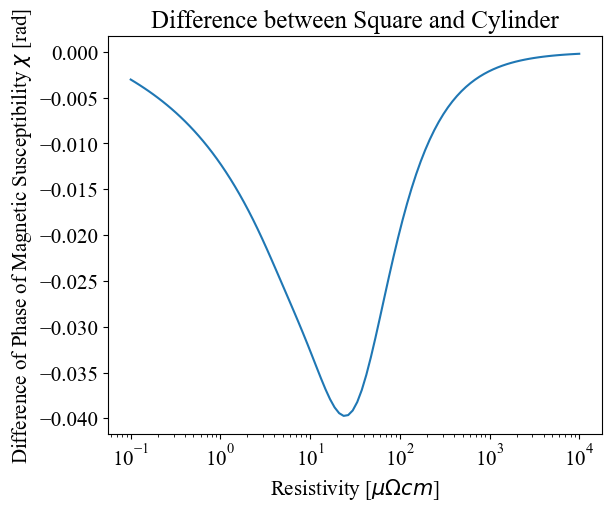

In [5]:
# Phase Behavior of Circle v Square

rhos = np.logspace(-9,-4,100)
chis = np.zeros(len(rhos),dtype=np.complex_) #Stores the effective magnetic susceptibility of cylinder
chis2 = np.zeros(len(rhos),dtype=np.complex_) #square
analchis = np.zeros(len(rhos),dtype=np.complex_)#analytical solution for cylinder
s = 1e-3 # length in meters
d = 2e-3/np.pi**.5 #diameter in meters
l = 2**(.5)*1e-3 #side length of the triangle
a=d/2 #radius

resolution = 150
H0 = 1
for i, rho in enumerate(rhos):
    delta = get_skin_depth(rho)
    k =(1-1j)/delta
    cylind = get_cylind_H(d,delta,resolution)
    Square = get_square_H(s,delta,resolution)
    chis[i] = double_Integral(cylind,d)/d**2-1
    chis2[i] = double_Integral(Square,s)/s**2-1
    analchis[i] = 2/a/k*jv(1,a*k)/jv(0,a*k)-1
Phase2Resistivty = interp1d(np.angle(analchis),rhos) #this is the big headline. Now we can convert a measured phase to resistivity

fig1 = plt.figure(constrained_layout = True)
fig2 = plt.figure(constrained_layout = True)
fig3 = plt.figure(constrained_layout = True, figsize=(6, 5))
ax = fig1.add_subplot(1, 2, 1)
bx = fig1.add_subplot(1, 2, 2)
cx = fig2.add_subplot(1, 1, 1)
dx = fig3.add_subplot(1, 1, 1)
ax.plot(rhos*1e8,chis.real)
ax.plot(rhos*1e8,chis.imag)
# ax.plot(rhos*1e8,np.absolute(chis))
ax.set_xscale('log')
ax.set_xlabel(r'Resistivity ($\mu \Omega cm$)')
ax.set_ylabel(r'Magnetic Susceptibility$\chi$')
ax.legend(['Real','Imaginary','Magnitude'])
ax.set_title(r'Cylinder Magnetic Susceptibility $\chi$')

bx.plot(rhos*1e8,chis2.real)
bx.plot(rhos*1e8,chis2.imag)
# bx.plot(rhos*1e8,np.absolute(chis2))
bx.set_xscale('log')
bx.set_xlabel(r'Resistivity ($\mu \Omega cm$)')
bx.set_ylabel(r'Magnetic Susceptibility$\chi$')
bx.legend(['Real','Imaginary','Magnitude'])
bx.set_title(r'Square Magnetic Susceptibility $\chi$')

cx.plot(np.angle(chis),rhos*1e8)
cx.plot(np.angle(chis2),rhos*1e8)
cx.set_yscale('log')
cx.set_ylabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
cx.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$ (rad)',fontsize = 15)
cx.set_title(r'Resistivity versus Phase of $\chi$ for 1 mm$^2$ Samples',fontsize = 18)
cx.legend(['Cylinder','Square'], fontsize=12)
cx.tick_params(axis='x', labelsize=15)
cx.tick_params(axis='y', labelsize=15)

dx.plot(rhos*1e8,np.angle(chis)-np.angle(chis2))
dx.set_xscale('log')
dx.set_title('Difference between Square and Cylinder',fontsize = 18)
dx.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
dx.set_ylabel(r'Difference of Phase of Magnetic Susceptibility $\chi$ (rad)',fontsize = 15)
dx.tick_params(axis='x', labelsize=15)
dx.tick_params(axis='y', labelsize=15)